In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime

In [2]:
df = pd.read_csv('consumer_data.csv', 
                 encoding='cp1251', 
                 parse_dates=['InvoiceDate'])

In [3]:
# InvoiceNo - идентификатор накладной
# StockCode - код товарной позиции
# Description - описание товара
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
# Товарных кодов больше, чем описаний товаров
# Вероятно, к одному коду привязано несколько написаний или несколько разных товарных позиций
df['StockCode'].nunique(), df['Description'].nunique()

(4070, 4223)

In [6]:
df.groupby('StockCode')['Description'].nunique().sort_values(ascending=False)

StockCode
20713     8
23084     7
21830     6
85175     6
23343     5
         ..
35969     0
20864     0
84664     0
20863     0
84964B    0
Name: Description, Length: 4070, dtype: int64

In [7]:
df[df['StockCode'] == '20713']['Description'].unique()

array(['JUMBO BAG OWLS', nan, 'wrongly marked. 23343 in box',
       'wrongly coded-23343', 'found', 'Found', 'wrongly marked 23343',
       'Marked as 23343', 'wrongly coded 23343'], dtype=object)

In [8]:
# Также есть коды, для которых не задано описание товарной позиции
# но у них нет количества купленного товара и цены, так что эти строки ценности для нас не представляют
df[df['StockCode'] == '84664']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
75241,542565,84664,NaN,-1,2011-01-28 14:52:00,0.0,NaN,United Kingdom


In [9]:
pd.isnull(df).sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
# удалим строки с Nan в CustomerID
df = df.drop(df[df['CustomerID'].isna()].index)

In [11]:
pd.isnull(df).sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [13]:
# проверим, сколько покупок в среднем приходится на одного покупателя
# вдруг нет смысла что-то тут кластеризовать
df['InvoiceNo'].nunique() / df['CustomerID'].nunique()

5.07548032936871

In [14]:
df['CustomerID'] = df['CustomerID'].astype(int).astype(str)
df['item_sum'] = df['Quantity'] * df['UnitPrice']

In [15]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,item_sum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [16]:
df['InvoiceDate'].min(), df['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

In [17]:
now = datetime(2011,12,10)

In [18]:
df_rfm = df.groupby('CustomerID').agg({
    #Recency
    'InvoiceDate': lambda x: (now - x.max()).days,
    #Frequency
    'InvoiceNo': 'nunique',
    #Monetary
    'item_sum': sum
})

df_rfm = df_rfm.rename(columns = {
    'InvoiceDate':'days_delta',
    'InvoiceNo':'cnt_orders',
    'item_sum':'total_sum'
})

In [19]:
df_rfm

,days_delta,cnt_orders,total_sum
CustomerID,,,
12346,325,2,0.00
12347,2,7,4310.00
12348,75,4,1797.24
12349,18,1,1757.55
12350,310,1,334.40
...,...,...,...
18280,277,1,180.60
18281,180,1,80.82
18282,7,3,176.60


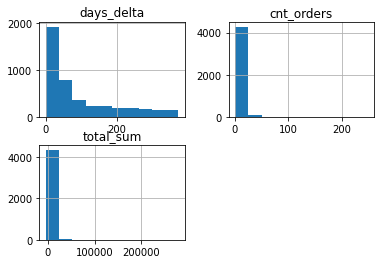

In [20]:
df_rfm.hist();

In [21]:
# по каждому из признаков выделяем по пять равных групп
# затем присваиваем каждой группе числовое обозначение от 1 до 5.

df_rfm['bin_recency'] = pd.qcut(df_rfm['days_delta'], 5, labels = [i for i in range(1, 6)])

bins = [0.999, df_rfm['cnt_orders'].quantile(1/5),
        df_rfm['cnt_orders'].quantile(2/5),
        df_rfm['cnt_orders'].quantile(3/5), 
        df_rfm['cnt_orders'].quantile(4/5), 
        df_rfm['cnt_orders'].quantile(5/5)]
df_rfm['bin_frequency'] = pd.cut(df_rfm['cnt_orders'], bins = bins, labels = [i for i in range(1, 6)])

df_rfm['bin_monetary'] = pd.qcut(df_rfm['total_sum'], 5, labels = [i for i in range(1, 6)])

In [ ]:
df_rfm.head()

In [ ]:
# представим в виде сводной
pd.pivot_table(df_rfm, 
               index=['bin_recency','bin_frequency'],
               columns='bin_monetary',
               values='total_sum',
               aggfunc='count').fillna(0)

In [24]:
# представим в виде сводной
pd.pivot_table(df_rfm, 
               index=['bin_recency','bin_frequency'],
               columns='bin_monetary',
               values='total_sum',
               aggfunc='count').fillna(0)

bin_monetary                 1    2   3   4    5
bin_recency bin_frequency                       
1           1               29   20   9   1    1
            2               18   37  27  17    3
            3                8   24  62  55   15
            4                2    3  24  94   63
            5                1    0   2  57  332
2           1               78   51  19   3    0
            2               25   50  51  10    3
            3                2   26  85  67   18
            4                0    1  28  95   53
            5                0    0   5  39  151
3           1              115   96  36  14    1
            2               31   57  63  21    5
            3               12   24  74  70   18
            4                1    6  25  74   43
            5                0    0   4  26   68
4           1              127   93  47  16    8
            2               33   59  80  32    4
            3               12   38  76  67   19
            4                4    5  23  41   29
            5                0    1   2  13   21
5           1              311  167  51  16    4
            2               55   76  41  18    1
            3               10   36  25  18    6
            4                1    2  13   7    4
            5                0    2   2   3    5

In [25]:
# можно еще добавить поле, куда добавим сконкатинированные строки с нашими признаками
# так проще фильтровать строки по интересущим группам
df_rfm['segments_concat'] = df_rfm[['bin_recency', 'bin_frequency', 'bin_monetary']].apply(
    lambda x: str(x['bin_recency']) + \
              str(x['bin_frequency']) + \
              str(x['bin_monetary']), 
    axis = 'columns')

In [26]:
df_rfm.head()

,days_delta,cnt_orders,total_sum,bin_recency,bin_frequency,bin_monetary,segments_concat
CustomerID,,,,,,,
12346,325,2,0.00,5,2,1,521
12347,2,7,4310.00,1,4,5,145
12348,75,4,1797.24,4,3,4,434
12349,18,1,1757.55,2,1,4,214
12350,310,1,334.40,5,1,2,512


In [27]:
# Например, нас интересуют лояльные нам покупатели, 
# которые недавно что-то заказывали, 
# в принципе заказывают часто и на большие суммы
df_rfm[df_rfm['segments_concat'] == '155'].head()

,days_delta,cnt_orders,total_sum,bin_recency,bin_frequency,bin_monetary,segments_concat
CustomerID,,,,,,,
12362,3,13,5154.58,1,5,5,155
12417,3,12,3578.80,1,5,5,155
12437,1,19,4896.66,1,5,5,155
12471,2,49,18740.92,1,5,5,155
12476,1,20,6546.58,1,5,5,155
